In [23]:
import os
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd # For playing audio in the notebook

# Set a nice style for plots
plt.style.use('seaborn-v0_8-whitegrid')
print(os.getcwd())

c:\Master\An 1 Sem 2\IACV\Pachet fisiere IAECV-Proiect\notebooks


In [24]:
# --- Configuration ---
BASE_DIR = '../' # Assuming your notebook is in 'notebooks/' and data is one level up
AUDIO_DIR = os.path.join(BASE_DIR, 'data/extrAudio/')
ANNOTATION_DIR = os.path.join(BASE_DIR, 'data/datasetAnnotation/')

print(f"Audio directory: {AUDIO_DIR}")
print(f"Annotation directory: {ANNOTATION_DIR}")

Audio directory: ../data/extrAudio/
Annotation directory: ../data/datasetAnnotation/


In [ ]:
def load_all_annotations(annotation_dir):
    all_annotations = []
    for csv_file in os.listdir(annotation_dir):
        if csv_file.endswith('.csv'):
            file_path = os.path.join(annotation_dir, csv_file)
            df = pd.read_csv(file_path)
            # Add filename and label (deceptive/sincere) to the dataframe
            df['audio_filename'] = csv_file.replace('.csv', '.wav')
            if 'trial_lie' in csv_file:
                df['label'] = 'deceptive'
            elif 'trial_truth' in csv_file:
                df['label'] = 'sincere'
            else:
                df['label'] = 'unknown' # Should not happen based on description
                print(f"Warning: Unknown label for file {csv_file}. Defaulting to 'unknown'.")
            all_annotations.append(df)
    
    if not all_annotations:
        print("No annotation files found or loaded. Check ANNOTATION_DIR.")
        return pd.DataFrame()
        
    return pd.concat(all_annotations, ignore_index=True)

raw_annotations_df = load_all_annotations(ANNOTATION_DIR)

if not raw_annotations_df.empty:
    print(f"--- Total utterances loaded (including TM): {len(raw_annotations_df)} ---")
    print(f"--- Original columns: {raw_annotations_df.columns.tolist()} ---")
    
    # ---  Filter out 'TM' Speakers from the Beginning ---
    # Ensure the column names 'Speaker', 'Start time', 'Stop time', 'Gender' are correct for your CSVs
    # (You confirmed these earlier: 'Start time', 'Stop time', 'Speaker', 'Gender')
    if 'Speaker' in raw_annotations_df.columns:
        annotations_df = raw_annotations_df[raw_annotations_df['Speaker'] != 'TM'].copy()
        # Using .copy() is good practice here to avoid SettingWithCopyWarning later
        print(f"--- Total utterances after filtering 'TM' speakers: {len(annotations_df)} ---")
    else:
        print("ERROR: 'Speaker' column not found in loaded annotations. Cannot filter 'TM'. Please check CSV headers.")
        annotations_df = raw_annotations_df # Proceed with unfiltered if 'Speaker' column is missing
else:
    annotations_df = pd.DataFrame() # Create an empty DataFrame if loading failed

--- Total utterances loaded (including TM): 1128 ---
--- Original columns: ['Start time', 'Stop time', 'Speaker', 'Gender', 'audio_filename', 'label'] ---
--- Total utterances after filtering 'TM' speakers: 929 ---


In [39]:
print("--- Columns in annotations_df ---")
print(annotations_df.columns.tolist()) 
# Or, to see the first few rows with column headers:
# print(annotations_df.head())

--- Columns in annotations_df ---
['Start time', 'Stop time', 'Speaker', 'Gender', 'audio_filename', 'label']


In [41]:
# --- Calculate Statistics (Now on the TM-filtered DataFrame) ---
if not annotations_df.empty:
    print("\n--- Statistics for SUBJECTS (TM speakers excluded) ---")

    # Number of unique audio files (recordings) for subjects
    num_subject_recordings = annotations_df['audio_filename'].nunique()
    print(f"Total number of unique audio recordings (subjects only): {num_subject_recordings}")

    subject_recordings_per_label = annotations_df.groupby('label')['audio_filename'].nunique()
    print(f"\nRecordings per label (subjects only):\n{subject_recordings_per_label}")

    # Total number of utterances for subjects
    total_subject_utterances = len(annotations_df)
    print(f"\nTotal number of utterances (subjects only): {total_subject_utterances}")

    # Utterances per label for subjects
    subject_utterances_per_label = annotations_df['label'].value_counts()
    print(f"\nUtterances per label (subjects only):\n{subject_utterances_per_label}")
    # Compare these counts to the documentation's 463 deceptive, 466 sincere.
    # Note: These numbers from the PDF might include 'TM' if 'TM' utterances were also labeled.
    # Your counts here will be strictly for non-'TM' speakers.

    # Number of unique subjects
    num_unique_subjects = annotations_df['Speaker'].nunique()
    print(f"\nTotal number of unique subjects: {num_unique_subjects}")
    # Expected from documentation: 56

    # Speaker gender distribution for subjects
    if 'Gender' in annotations_df.columns:
        subject_gender_distribution = annotations_df.drop_duplicates(subset=['Speaker'])['Gender'].value_counts()
        print(f"\nSubject gender distribution:\n{subject_gender_distribution}")
        # Expected from documentation: 22 Female, 34 Male
    else:
        print("\n'Gender' column not found. Cannot calculate gender distribution.")
else:
    print("Annotations DataFrame is empty or 'Speaker' column was missing. No statistics calculated.")



--- Statistics for SUBJECTS (TM speakers excluded) ---
Total number of unique audio recordings (subjects only): 120

Recordings per label (subjects only):
label
deceptive    60
sincere      60
Name: audio_filename, dtype: int64

Total number of utterances (subjects only): 929

Utterances per label (subjects only):
label
sincere      466
deceptive    463
Name: count, dtype: int64

Total number of unique subjects: 63

Subject gender distribution:
Gender
M    35
F    28
Name: count, dtype: int64


### trial_lie_051 is only TM so there is a total of 60 deceptive and 60 sincere audios



--- Exploring Sample Utterance ---
Audio file: trial_lie_001.wav
Start time: 0.37s
Stop time: 1.63s
Label: deceptive
Successfully loaded trial_lie_001.wav, Sample rate: 16000 Hz, Duration: 16.96s
Extracted utterance duration: 1.26s

Playing sample utterance:


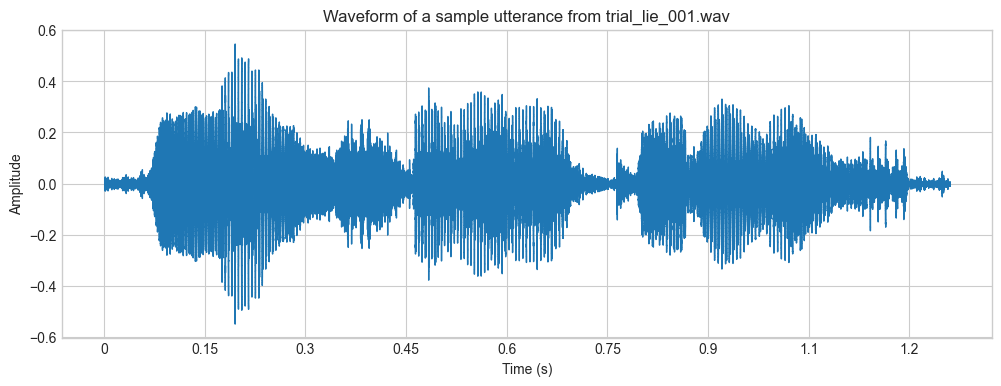

In [42]:
# Let's pick one utterance to explore
if not annotations_df.empty:
    sample_utterance = annotations_df.iloc[0]
    sample_audio_filename = sample_utterance['audio_filename']
    sample_audio_path = os.path.join(AUDIO_DIR, sample_audio_filename)

    print(f"\n--- Exploring Sample Utterance ---")
    print(f"Audio file: {sample_audio_filename}")
    print(f"Start time: {sample_utterance['Start time']}s")
    print(f"Stop time: {sample_utterance['Stop time']}s")
    print(f"Label: {sample_utterance['label']}")

    # Load the full audio file
    # The project states audio is 16kHz. librosa loads at 22050Hz by default.
    try:
        y_full, sr = librosa.load(sample_audio_path, sr=16000) # Load at 16kHz as specified
        print(f"Successfully loaded {sample_audio_filename}, Sample rate: {sr} Hz, Duration: {len(y_full)/sr:.2f}s")

        # Extract the specific utterance
        start_sample = librosa.time_to_samples(sample_utterance['Start time'], sr=sr)
        end_sample = librosa.time_to_samples(sample_utterance['Stop time'], sr=sr)
        y_utterance = y_full[start_sample:end_sample]
        
        utterance_duration = len(y_utterance) / sr
        print(f"Extracted utterance duration: {utterance_duration:.2f}s")

        # Play the utterance (optional, works in Jupyter)
        print("\nPlaying sample utterance:")
        ipd.display(ipd.Audio(y_utterance, rate=sr))

        # Visualize the waveform of the utterance
        plt.figure(figsize=(12, 4))
        librosa.display.waveshow(y_utterance, sr=sr)
        plt.title(f"Waveform of a sample utterance from {sample_audio_filename}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.show()

    except Exception as e:
        print(f"Error loading or processing {sample_audio_path}: {e}")
else:
    print("Annotations DataFrame is empty. Skipping audio exploration.")


--- Utterance Duration Statistics ---
count    929.000000
mean       2.430205
std        1.853970
min        0.110000
25%        1.050000
50%        1.890000
75%        3.380000
max       11.900000
Name: utterance_duration_sec, dtype: float64


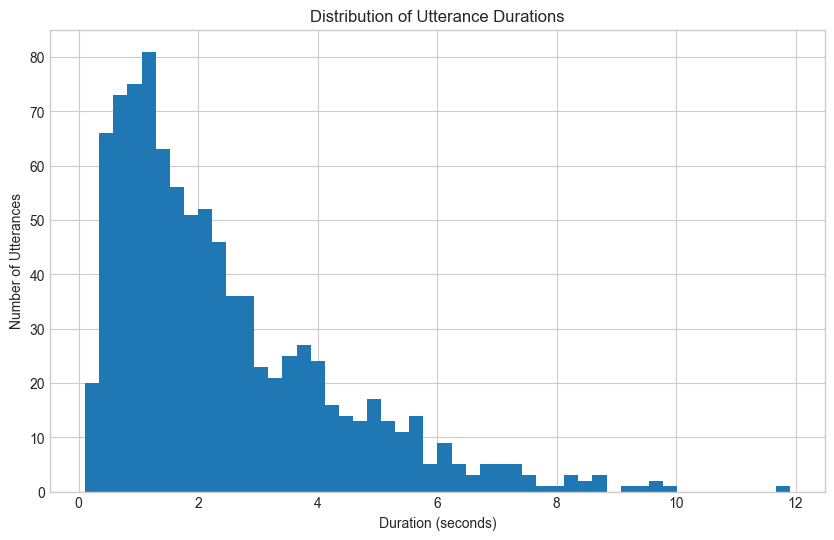

In [43]:
if not annotations_df.empty:
    annotations_df['utterance_duration_sec'] = annotations_df['Stop time'] - annotations_df['Start time']

    print("\n--- Utterance Duration Statistics ---")
    print(annotations_df['utterance_duration_sec'].describe())

    plt.figure(figsize=(10, 6))
    annotations_df['utterance_duration_sec'].hist(bins=50)
    plt.title("Distribution of Utterance Durations")
    plt.xlabel("Duration (seconds)")
    plt.ylabel("Number of Utterances")
    plt.show()
else:
    print("Annotations DataFrame is empty. Skipping utterance duration analysis.")